# Cross-Validation using Decision Trees and Logistic Regression (with Scaling)

This Jupyter Notebook uses cross-validation for evaluation of model performing, using 2 Machine Learning Classification Models: Decision Tree and Logistic Regression (with scaling applied to the input data).

## Approach
* Evaluations of classification performed were performed using 2 sample datasets:
    * sklearn's Iris sample dataset, consisting of 150 sample data points for 3 varieties of iris flowers
    * voice dataset, containing 3168 sample data points of male and female speakers

* Classification model score (R^2) was evaluated in 3 ways:
    * Model score using Testing Data
    * Model score using Training Data
    * Cross-Validation model score using Training Data (with 5 folds)
    
* Cross-Validation scores and Training Data scores were used to calculate a percentage "inflation": the percent difference between the 2 sets of scores relative to the cross-validation scores.  These results were then plotted
    
## Results
* Refer to the Figure and Table of results provided below
* The Logistic Regression classifier showed little variation between model scores with similar model parameters when scoring was performed with or without cross-validation.  The "inflation" of the direct score vs. cross-validation score was less than 1.6% for this classifier, and less than 0.4% with the Voice dataset.
* For the Decision Tree classifier, model performance was scored up to 9.4% higher using the direct model score vs. a cross-validation score.
* Additional investigation comparing (cross validation score - testing data score) vs. (training data score - testing data score) would provide a view of which scoring approach provides an estimate closest to the testing data score.


| Figure: Cross-Validation Scoring for Decision Tree and Logistic Regression |
| :----------: |
| ![Figure: Cross-Validation Scoring for Decision Tree and Logistic Regression is Loading...](docs/Figure-Cross_Validation_vs_Direct.png "Figure: Cross-Validation Scoring for Decision Tree and Logistic Regression") |

| Table: Cross-Validation Scoring for Decision Tree and Logistic Regression |
| :----------: |
| ![Table: Cross-Validation Model Performance for Decision Tree and Logistic Regression is Loading...](docs/Table-Cross_Validation_vs_Direct.png "Table: Cross-Validation Scoring for Decision Tree and Logistic Regression") |


# Dependencies

In [1]:
%matplotlib inline
# %matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D    # Support 3D graphing

import numpy as np
import pandas as pd
from pandas.plotting import table
import math

from pprint import pprint

# Visualization
import graphviz
import pydotplus
from IPython.display import Image

# Machine Learning - Linear Models - Regression
from sklearn.linear_model import LinearRegression  # TBD
from sklearn.linear_model import Lasso             # TBD
from sklearn.linear_model import Ridge             # TBD
from sklearn.linear_model import ElasticNet        # TBD

# Machine Learning - Linear Models - Classification
from sklearn.linear_model import LogisticRegression   # Linear model for classification

# Machine Learning - Decision Trees and Random Forests - Classification
from sklearn import tree                             # Decision Tree Classifer
from sklearn.ensemble import RandomForestClassifier  # Random Forest Classifer

# Machine Learning - Data Preparation and Pre-Processing
from sklearn.model_selection import train_test_split # Split data into training and testing samples
from sklearn.model_selection import cross_val_score  # Score a model using k-fold or other cross validation

from sklearn.preprocessing import OneHotEncoder   # Convert categorical integer features (X) to One-Hot encoded values
from sklearn.preprocessing import LabelEncoder    # Convert categorical labeled values to categorical integer values
from sklearn.preprocessing import LabelBinarizer  # Convert categorical labeled values to Binary encoded values

from sklearn.preprocessing import StandardScaler  # Scale numerical features to standard normal distribution
from sklearn.preprocessing import MinMaxScaler    # Scale numerical values based upon mix/max values

# Machine Learning - Quantify Model Performance
from sklearn.metrics import mean_squared_error   # Mean Squared Error (MSE) metric
from sklearn.metrics import r2_score             # R-squared (Coefficient of Determination) metric
from sklearn.metrics import confusion_matrix     # Generate a confusion matrix (actual vs. predicted counts)

# Machine Learning - Dataset Generation
from sklearn.datasets import make_regression     # Generate linear data
from sklearn.datasets import make_s_curve        # Generate nonlinear data
from sklearn.datasets import make_blobs          # Generate blobs for classification
from sklearn.datasets import make_circles        # Generate circles for classification
from sklearn.datasets import load_iris           # Sample multi-class dataset for classification

C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Cross-Validation using Decision Trees and Logistic Regression (with Scaling)

# Iris Dataset

In [2]:
# Import the Iris sample dataset as a dictionary
iris = load_iris()

print( f"Iris {iris.keys()}" )
print( f"Feature Names: {iris.feature_names}" )
print( f"Target Names: {iris.target_names}" )

Iris dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])
Feature Names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target Names: ['setosa' 'versicolor' 'virginica']


In [3]:
# Assign data and target variables
X = iris.data
y = iris.target
print( X.shape, y.shape )

(150, 4) (150,)


In [4]:
# Split the data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [5]:
# Reshape the outputs to provide a N by 1 vector (vs. array of size N)
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print(y_train.shape, y_test.shape)

(112, 1) (38, 1)


In [6]:
# Use the training data to create a scaler to standard normal distributions for each numerical feature and output
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
# Scale the training and test data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [8]:
# a_p_dict = classifier.get_params()

# LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
#           intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
#           penalty='l2', random_state=None, solver='saga', tol=0.0001,
#           verbose=0, warm_start=False)

# {'C': 1.0,
#  'class_weight': None,
#  'dual': False,
#  'fit_intercept': True,
#  'intercept_scaling': 1,
#  'max_iter': 1000,
#  'multi_class': 'ovr',
#  'n_jobs': 1,
#  'penalty': 'l2',
#  'random_state': None,
#  'solver': 'saga',
#  'tol': 0.0001,
#  'verbose': 0,
#  'warm_start': False}

# DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
#             max_features=None, max_leaf_nodes=None,
#             min_impurity_decrease=0.0, min_impurity_split=None,
#             min_samples_leaf=1, min_samples_split=2,
#             min_weight_fraction_leaf=0.0, presort=False, random_state=None,
#             splitter='best')

# {'class_weight': None,
#  'criterion': 'gini',
#  'max_depth': 1,
#  'max_features': None,
#  'max_leaf_nodes': None,
#  'min_impurity_decrease': 0.0,
#  'min_impurity_split': None,
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'min_weight_fraction_leaf': 0.0,
#  'presort': False,
#  'random_state': None,
#  'splitter': 'best'}

### Function to Fit Model, Evaluate Performance - Iris Dataset

In [9]:
# Function to fit a model to training data, calculate predictions, and create a residuals chart
def eval_classifier(a_model):
    # Get the model information
    m_info = str(a_model)
    
    # Get the name of this model
    m_name = m_info.split("(",1)[0]
    
    # Get the parameters used with the model
    m_params = a_model.get_params()
    
    # Get the solver -- if this is supported with this model (e.g., LinearRegression)
    try:
        m_solver = m_params['solver']
    except:
        m_solver = None
    
    # Get maximum iterations -- if this is supported with this model (e.g., DecisionTree)
    try:
        m_max_iter = m_params['max_iter']
    except:
        m_max_iter = None
    
    # Get max_depth -- if this is supported with this model (e.g., DecisionTree)
    try:
        m_max_depth = m_params['max_depth']
    except:
        m_max_depth = None

    # Print a separator
    print("*"*80)

    # Print the model attributes
#     print(a_model)
    
    # Fit the data to the scaled data
    m_fit_time = %timeit -n1 -r1 -o a_model.fit(X_train_scaled, y_train.reshape(-1))

    # Calculate Model performance: MSE and R2
    m_score_test = a_model.score(X_test_scaled, y_test)
    m_score_train = a_model.score(X_train_scaled, y_train)
    
    # Calculate Model performance using Cross Validation
    m_score_cv_train = cross_val_score(a_model, X_train_scaled, y_train.reshape(-1), cv=5)

    # Post-Fit Info: # of Iterations required to fit the model - if it is supported by this model
    try:
        m_n_iter = a_model.n_iter_
        
    except:
        m_n_iter = None

    try:
        m_tot_n_iter = sum(m_n_iter)
        
    except:
        m_tot_n_iter = None
                  
    # Post-Fit Info: Linear coefficients and y-intercept - if it is supported by this model
    try:
        m_coef = a_model.ceof_
        m_intercept = a_model.intercept_
        
    except:
        m_coef = None
        m_intercept = None

    print(f"\nModel: {m_name}, Solver: {m_solver}, Max Iterations: {m_max_iter}, Iterations: {m_tot_n_iter} {m_n_iter}, Max Depth: {m_max_depth}")
    print(f"Test Data - Model Score: {m_score_test}")
    print(f"Training Data - Model Score (Direct): {m_score_train}")
    print(f"Training Data - Model Score (Cross Validation): {m_score_cv_train}")
    print(f"Fit Attributes - coef_: {m_coef}, intercept_: {m_intercept}")
    
    # Make predictions using both test and training data
    y_predicted_test = a_model.predict(X_test_scaled)
    y_predicted_train = a_model.predict(X_train_scaled)
    
    # Generate a confusion matrix of the results for both test and training data
    cm_test = confusion_matrix(y_test, a_model.predict(X_test_scaled))
    print("\nConfusion Matrix - Testing Data")
    print(cm_test)

    cm_train = confusion_matrix(y_train, a_model.predict(X_train_scaled))
    print("\nConfusion Matrix - Training Data")
    print(cm_train)
    
    # Feature Importances
    try:
        f_impt_df = pd.DataFrame(
                    { 'factor': iris.feature_names, 'importance': classifier.feature_importances_ }) \
                    .sort_values(by='importance', ascending=False)
            
        print("\nFeature Importances")
        print(f_impt_df[['factor', 'importance']])
        
    except:
        pass
    
    
    # Return the -results
    a_result = {
        'model': m_name,
        'score_test': m_score_test,
        'score_train': m_score_train,
        'score_cv_train': m_score_cv_train,
        'score_cv_train_avg': np.mean(m_score_cv_train),
        'score_cv_train_std': np.std(m_score_cv_train),
        'solver': m_solver,
        'max_iter': m_max_iter,
        'n_iter': m_n_iter,
        'tot_n_iter': m_tot_n_iter,
        'max_depth': m_max_depth,
        'coef': m_coef,
        'intercept': m_intercept,
        'fit_time': m_fit_time.average,
        'fit_time_TimeitResult': m_fit_time
    }
        
    return a_result

# Classification Model: Logistic Regression - Iris Dataset

### Logistic Regression: Iterate Model Parameter - Solver - Iris Dataset

In [10]:
# Initialize list of dictionary of results for summary in a dataframe later
model_results = []

# List of Solvers to use with LogisticRegression model
solver_list = "liblinear", "newton-cg", "lbfgs", "sag", "saga"

# Generate classifer and an associated performance report for each
for s in solver_list:
    # Create a classifier model
    classifier = LogisticRegression(solver=s, n_jobs=1, max_iter=1000)
    
    # Evaluate the classifer performance, create a plot    
    r = eval_classifier(classifier)
    
    model_results.append( {
        'Dataset': 'Iris',
        'Classifier': r['model'],
        'Solver': r['solver'],
        'Iterations': r['n_iter'],
        'Total Iterations': r['tot_n_iter'],
        'Max Tree Depth': r['max_depth'],
        'Score-Testing Data': r['score_test'],
        'Score-Training Data': r['score_train'],
        'Score-CV-Training Data': r['score_cv_train'],
        'Score-CV-Training Data-Avg': r['score_cv_train_avg'],
        'Score-CV-Training Data-Std': r['score_cv_train_std'],
        'Fit Time (ms)': 1000.0*r['fit_time'],
        'Coefficients': r['coef'],
        'Intercept': r['intercept']
        } )
    
    print("")

********************************************************************************
27.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Model: LogisticRegression, Solver: liblinear, Max Iterations: 1000, Iterations: 6 [6], Max Depth: None
Test Data - Model Score: 0.8947368421052632
Training Data - Model Score (Direct): 0.9017857142857143
Training Data - Model Score (Cross Validation): [0.875      0.70833333 0.95454545 1.         0.9047619 ]
Fit Attributes - coef_: None, intercept_: None

Confusion Matrix - Testing Data
[[12  0  0]
 [ 0 10  3]
 [ 0  1 12]]

Confusion Matrix - Training Data
[[37  1  0]
 [ 0 30  7]
 [ 0  3 34]]

********************************************************************************
13.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Model: LogisticRegression, Solver: newton-cg, Max Iterations: 1000, Iterations: 25 [10  7  8], Max Depth: None
Test Data - Model Score: 0.9473684210526315
Training Data - Model Score (Direct): 0.9107142857142

### Logistic Regression: Summary - Iris Dataset

In [11]:
summary_lr_iris_df = pd.DataFrame( model_results,
          columns=['Dataset', 'Classifier', 'Solver', 'Iterations', 'Total Iterations', 'Max Tree Depth', 'Fit Time (ms)', 'Score-Testing Data', 'Score-Training Data', 'Score-CV-Training Data', 'Score-CV-Training Data-Avg', 'Score-CV-Training Data-Std'])

summary_lr_iris_df

,Dataset,Classifier,Solver,Iterations,Total Iterations,Max Tree Depth,Fit Time (ms),Score-Testing Data,Score-Training Data,Score-CV-Training Data,Score-CV-Training Data-Avg,Score-CV-Training Data-Std
0,Iris,LogisticRegression,liblinear,[6],6,None,27.2255,0.894737,0.901786,"[0.875, 0.7083333333333334, 0.9545454545454546...",0.888528,0.099701
1,Iris,LogisticRegression,newton-cg,"[10, 7, 8]",25,None,13.7873,0.947368,0.910714,"[0.875, 0.75, 0.9545454545454546, 1.0, 0.90476...",0.896861,0.084940
2,Iris,LogisticRegression,lbfgs,"[13, 14, 15]",42,None,7.4660,0.947368,0.910714,"[0.875, 0.75, 0.9545454545454546, 1.0, 0.90476...",0.896861,0.084940
3,Iris,LogisticRegression,sag,"[18, 23, 17]",58,None,4.4075,0.947368,0.910714,"[0.875, 0.75, 0.9545454545454546, 1.0, 0.90476...",0.896861,0.084940
4,Iris,LogisticRegression,saga,"[46, 41, 54]",141,None,8.6618,0.947368,0.910714,"[0.875, 0.75, 0.9545454545454546, 1.0, 0.90476...",0.896861,0.084940


In [12]:
summary_lr_iris_df.mean()

Total Iterations              54.400000
Fit Time (ms)                 12.309620
Score-Testing Data             0.936842
Score-Training Data            0.908929
Score-CV-Training Data-Avg     0.895195
Score-CV-Training Data-Std     0.087892
dtype: float64

## Classification Model: Decision Tree - Iris Dataset

### Decision Tree: Iterate Models Parameter - Max Tree Depth - Iris Dataset

In [13]:
# Initialize list of dictionary of results for summary in a dataframe later
model_results = []

# List of tree max depth values over which to iterate
max_depth_list = [ None, 16, 8, 4, 2, 1 ]

# Generate classifer and an associated performance report for each
for md in max_depth_list:
    # Create a classifier model
    classifier = tree.DecisionTreeClassifier(max_depth=md)
    
    # Evaluate the classifer performance, create a plot of 
    r = eval_classifier(classifier)
    
    model_results.append( {
        'Dataset': 'Iris',
        'Classifier': r['model'],
        'Solver': r['solver'],
        'Iterations': r['n_iter'],
        'Total Iterations': r['tot_n_iter'],
        'Max Tree Depth': r['max_depth'],
        'Score-Testing Data': r['score_test'],
        'Score-Training Data': r['score_train'],
        'Score-CV-Training Data': r['score_cv_train'],
        'Score-CV-Training Data-Avg': r['score_cv_train_avg'],
        'Score-CV-Training Data-Std': r['score_cv_train_std'],
        'Fit Time (ms)': 1000.0*r['fit_time'],
        'Coefficients': r['coef'],
        'Intercept': r['intercept']
        } )
    
    print("")

********************************************************************************
1.01 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Model: DecisionTreeClassifier, Solver: None, Max Iterations: None, Iterations: None None, Max Depth: None
Test Data - Model Score: 0.9736842105263158
Training Data - Model Score (Direct): 1.0
Training Data - Model Score (Cross Validation): [0.875      0.79166667 1.         0.9047619  1.        ]
Fit Attributes - coef_: None, intercept_: None

Confusion Matrix - Testing Data
[[12  0  0]
 [ 0 13  0]
 [ 0  1 12]]

Confusion Matrix - Training Data
[[38  0  0]
 [ 0 37  0]
 [ 0  0 37]]

Feature Importances
              factor  importance
3   petal width (cm)    0.560702
2  petal length (cm)    0.403581
0  sepal length (cm)    0.035717
1   sepal width (cm)    0.000000

********************************************************************************
585 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Model: DecisionTreeClassifier, Solv

616 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


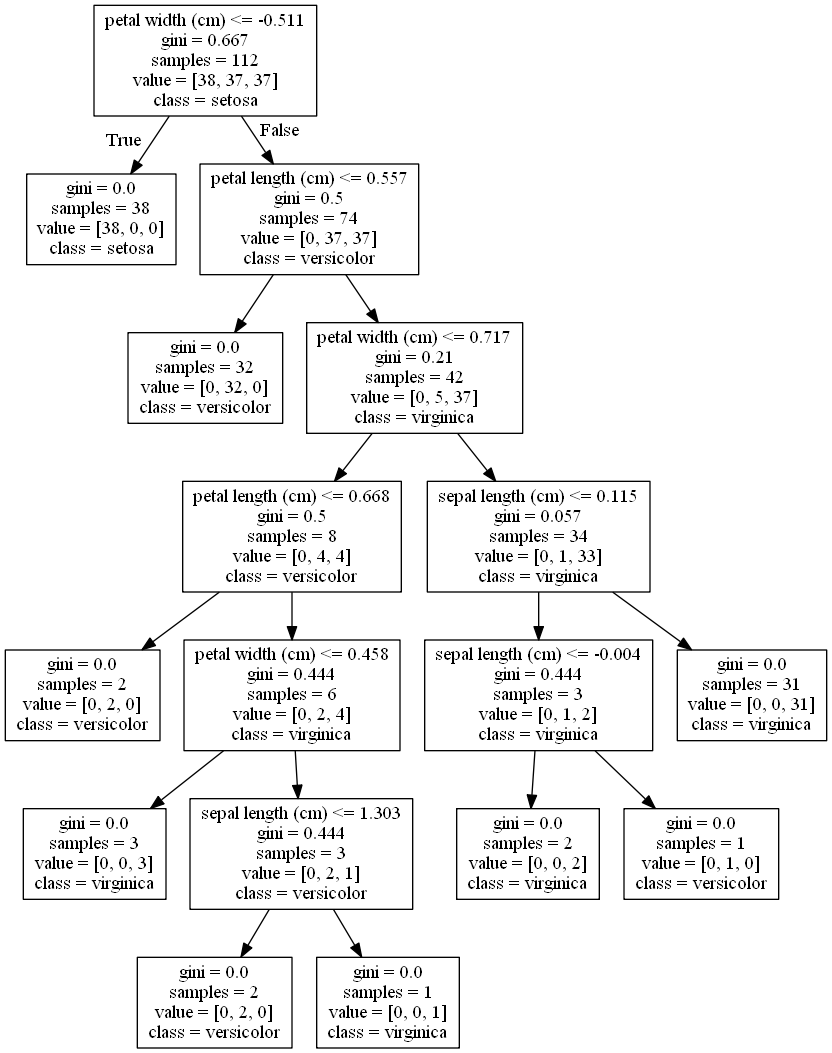

In [14]:
# Decision Tree plot
# Create the classifier
classifier = tree.DecisionTreeClassifier(max_depth=None)

# Fit the model
m_fit_time = %timeit -n1 -r1 -o classifier.fit(X_train_scaled, y_train.reshape(-1))

# Export the decision tree
dot_data = tree.export_graphviz( classifier, out_file = None,
                         class_names=iris.target_names,
                         feature_names=iris.feature_names)

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png() )


### Decision Tree - Scaled: Summary - Iris Dataset

In [15]:
summary_dt_iris_df = pd.DataFrame( model_results,
          columns=['Dataset', 'Classifier', 'Solver', 'Iterations', 'Total Iterations', 'Max Tree Depth', 'Fit Time (ms)', 'Score-Testing Data', 'Score-Training Data', 'Score-CV-Training Data', 'Score-CV-Training Data-Avg', 'Score-CV-Training Data-Std'])
summary_dt_iris_df

,Dataset,Classifier,Solver,Iterations,Total Iterations,Max Tree Depth,Fit Time (ms),Score-Testing Data,Score-Training Data,Score-CV-Training Data,Score-CV-Training Data-Avg,Score-CV-Training Data-Std
0,Iris,DecisionTreeClassifier,None,None,None,NaN,1.0084,0.973684,1.000000,"[0.875, 0.7916666666666666, 1.0, 0.90476190476...",0.914286,0.079200
1,Iris,DecisionTreeClassifier,None,None,None,16.0,0.5846,0.973684,1.000000,"[0.875, 0.7916666666666666, 1.0, 0.90476190476...",0.914286,0.079200
2,Iris,DecisionTreeClassifier,None,None,None,8.0,0.6209,0.973684,1.000000,"[0.9166666666666666, 0.7916666666666666, 1.0, ...",0.932143,0.076931
3,Iris,DecisionTreeClassifier,None,None,None,4.0,0.4625,0.973684,0.973214,"[0.9166666666666666, 0.7916666666666666, 1.0, ...",0.922619,0.076783
4,Iris,DecisionTreeClassifier,None,None,None,2.0,0.5242,0.947368,0.955357,"[0.9583333333333334, 0.875, 1.0, 0.85714285714...",0.928571,0.053901
5,Iris,DecisionTreeClassifier,None,None,None,1.0,0.4465,0.657895,0.669643,"[0.6666666666666666, 0.6666666666666666, 0.681...",0.669697,0.006061


In [16]:
summary_dt_iris_df.mean()

Max Tree Depth                6.200000
Fit Time (ms)                 0.607850
Score-Testing Data            0.916667
Score-Training Data           0.933036
Score-CV-Training Data-Avg    0.880267
Score-CV-Training Data-Std    0.062013
dtype: float64

# Voice Dataset

In [17]:
## Import Data and Pre-Process: Voice Dataset
voice = pd.read_csv('resources/voice.csv')
voice.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,...,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,...,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,...,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,...,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,...,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,...,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [18]:
# Check datatypes to ensure numerical values are floats vs. objects -- CONFIRMED
# voice.dtypes

In [19]:
# Assign X (data) and y (target)
X = voice.drop("label", axis=1)
y = voice["label"]
print(X.shape, y.shape)

(3168, 20) (3168,)


In [20]:
# Encode the output strings using a Categorical Binarizer
label_encoder = LabelBinarizer()
y_encoded = label_encoder.fit_transform(y)

In [21]:
# Split the data using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, random_state=1, stratify=y_encoded)

In [22]:
# Reshape the outputs to provide a N by 1 vector (vs. array of size N)
# y_train = y_train.reshape(-1,1)
# y_test = y_test.reshape(-1,1)
# print(y_train.shape, y_test.shape)

In [23]:
# Use the training data to create a scaler to standard normal distributions for each numerical feature and output
X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [24]:
# Scale the training and test data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Classification Model: Logistic Regression - Voice Dataset

### Logistic Regression: Iterate Model Parameter - Solver - Voice

In [25]:
# Initialize list of dictionary of results for summary in a dataframe later
model_results = []

# List of Solvers to use with LogisticRegression model
solver_list = "liblinear", "newton-cg", "lbfgs", "sag", "saga"

# Generate classifer and an associated performance report for each
for s in solver_list:
    # Create a classifier model
    classifier = LogisticRegression(solver=s, n_jobs=1, max_iter=1000)
        
    # Evaluate the classifer performance, create a plot of 
    r = eval_classifier(classifier)
    
    model_results.append( {
        'Dataset': 'Voice',
        'Classifier': r['model'],
        'Solver': r['solver'],
        'Iterations': r['n_iter'],
        'Total Iterations': r['tot_n_iter'],
        'Max Tree Depth': r['max_depth'],
        'Score-Testing Data': r['score_test'],
        'Score-Training Data': r['score_train'],
        'Score-CV-Training Data': r['score_cv_train'],
        'Score-CV-Training Data-Avg': r['score_cv_train_avg'],
        'Score-CV-Training Data-Std': r['score_cv_train_std'],
        'Fit Time (ms)': 1000.0*r['fit_time'],
        'Coefficients': r['coef'],
        'Intercept': r['intercept']
        } )
    
    print("")

********************************************************************************
10.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Model: LogisticRegression, Solver: liblinear, Max Iterations: 1000, Iterations: 7 [7], Max Depth: None
Test Data - Model Score: 0.9772727272727273
Training Data - Model Score (Direct): 0.9730639730639731
Training Data - Model Score (Cross Validation): [0.97058824 0.97268908 0.96638655 0.97679325 0.96413502]
Fit Attributes - coef_: None, intercept_: None

Confusion Matrix - Testing Data
[[387   9]
 [  9 387]]

Confusion Matrix - Training Data
[[1149   39]
 [  25 1163]]

********************************************************************************
34.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Model: LogisticRegression, Solver: newton-cg, Max Iterations: 1000, Iterations: 14 [14], Max Depth: None
Test Data - Model Score: 0.9772727272727273
Training Data - Model Score (Direct): 0.9722222222222222
Training Data - Model Scor

### Logistic Regression - Scaled: Summary - Voice Dataset

In [26]:
summary_lr_voice_df = pd.DataFrame( model_results,
          columns=['Dataset', 'Classifier', 'Solver', 'Iterations', 'Total Iterations', 'Max Tree Depth', 'Fit Time (ms)', 'Score-Testing Data', 'Score-Training Data', 'Score-CV-Training Data', 'Score-CV-Training Data-Avg', 'Score-CV-Training Data-Std'])
summary_lr_voice_df

,Dataset,Classifier,Solver,Iterations,Total Iterations,Max Tree Depth,Fit Time (ms),Score-Testing Data,Score-Training Data,Score-CV-Training Data,Score-CV-Training Data-Avg,Score-CV-Training Data-Std
0,Voice,LogisticRegression,liblinear,[7],7,None,10.1528,0.977273,0.973064,"[0.9705882352941176, 0.9726890756302521, 0.966...",0.970118,0.004497
1,Voice,LogisticRegression,newton-cg,[14],14,None,34.8189,0.977273,0.972222,"[0.9705882352941176, 0.9726890756302521, 0.966...",0.970540,0.003986
2,Voice,LogisticRegression,lbfgs,[49],49,None,24.2962,0.977273,0.972222,"[0.9705882352941176, 0.9726890756302521, 0.966...",0.970540,0.003986
3,Voice,LogisticRegression,sag,[90],90,None,142.0015,0.977273,0.972222,"[0.9705882352941176, 0.9726890756302521, 0.966...",0.970540,0.003986
4,Voice,LogisticRegression,saga,[152],152,None,246.8959,0.977273,0.972222,"[0.9705882352941176, 0.9726890756302521, 0.966...",0.970540,0.003986


In [27]:
summary_lr_voice_df.mean()

Total Iterations              62.400000
Fit Time (ms)                 91.633060
Score-Testing Data             0.977273
Score-Training Data            0.972391
Score-CV-Training Data-Avg     0.970456
Score-CV-Training Data-Std     0.004088
dtype: float64

## Classification Model: Decision Tree - Voice Dataset

### Decision Tree: Iterate Models Parameter - Max Tree Depth - Voice Dataset

In [28]:
# Initialize list of dictionary of results for summary in a dataframe later
model_results = []

# List of tree max depth values over which to iterate
max_depth_list = [ None, 16, 8, 4, 2, 1 ]

# Generate classifer and an associated performance report for each
for md in max_depth_list:
    # Create a classifier model
    classifier = tree.DecisionTreeClassifier(max_depth=md)
    
    # Evaluate the classifer performance, create a plot of 
    r = eval_classifier(classifier)
    
    model_results.append( {
        'Dataset': 'Voice',
        'Classifier': r['model'],
        'Solver': r['solver'],
        'Iterations': r['n_iter'],
        'Total Iterations': r['tot_n_iter'],
        'Max Tree Depth': r['max_depth'],
        'Score-Testing Data': r['score_test'],
        'Score-Training Data': r['score_train'],
        'Score-CV-Training Data': r['score_cv_train'],
        'Score-CV-Training Data-Avg': r['score_cv_train_avg'],
        'Score-CV-Training Data-Std': r['score_cv_train_std'],
        'Fit Time (ms)': 1000.0*r['fit_time'],
        'Coefficients': r['coef'],
        'Intercept': r['intercept']
        } )

    print("")

********************************************************************************
34.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Model: DecisionTreeClassifier, Solver: None, Max Iterations: None, Iterations: None None, Max Depth: None
Test Data - Model Score: 0.9696969696969697
Training Data - Model Score (Direct): 1.0
Training Data - Model Score (Cross Validation): [0.96848739 0.97268908 0.96638655 0.95991561 0.9535865 ]
Fit Attributes - coef_: None, intercept_: None

Confusion Matrix - Testing Data
[[386  10]
 [ 14 382]]

Confusion Matrix - Training Data
[[1188    0]
 [   0 1188]]

********************************************************************************
32.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)

Model: DecisionTreeClassifier, Solver: None, Max Iterations: None, Iterations: None None, Max Depth: 16
Test Data - Model Score: 0.9722222222222222
Training Data - Model Score (Direct): 1.0
Training Data - Model Score (Cross Validation): [0.962

33.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


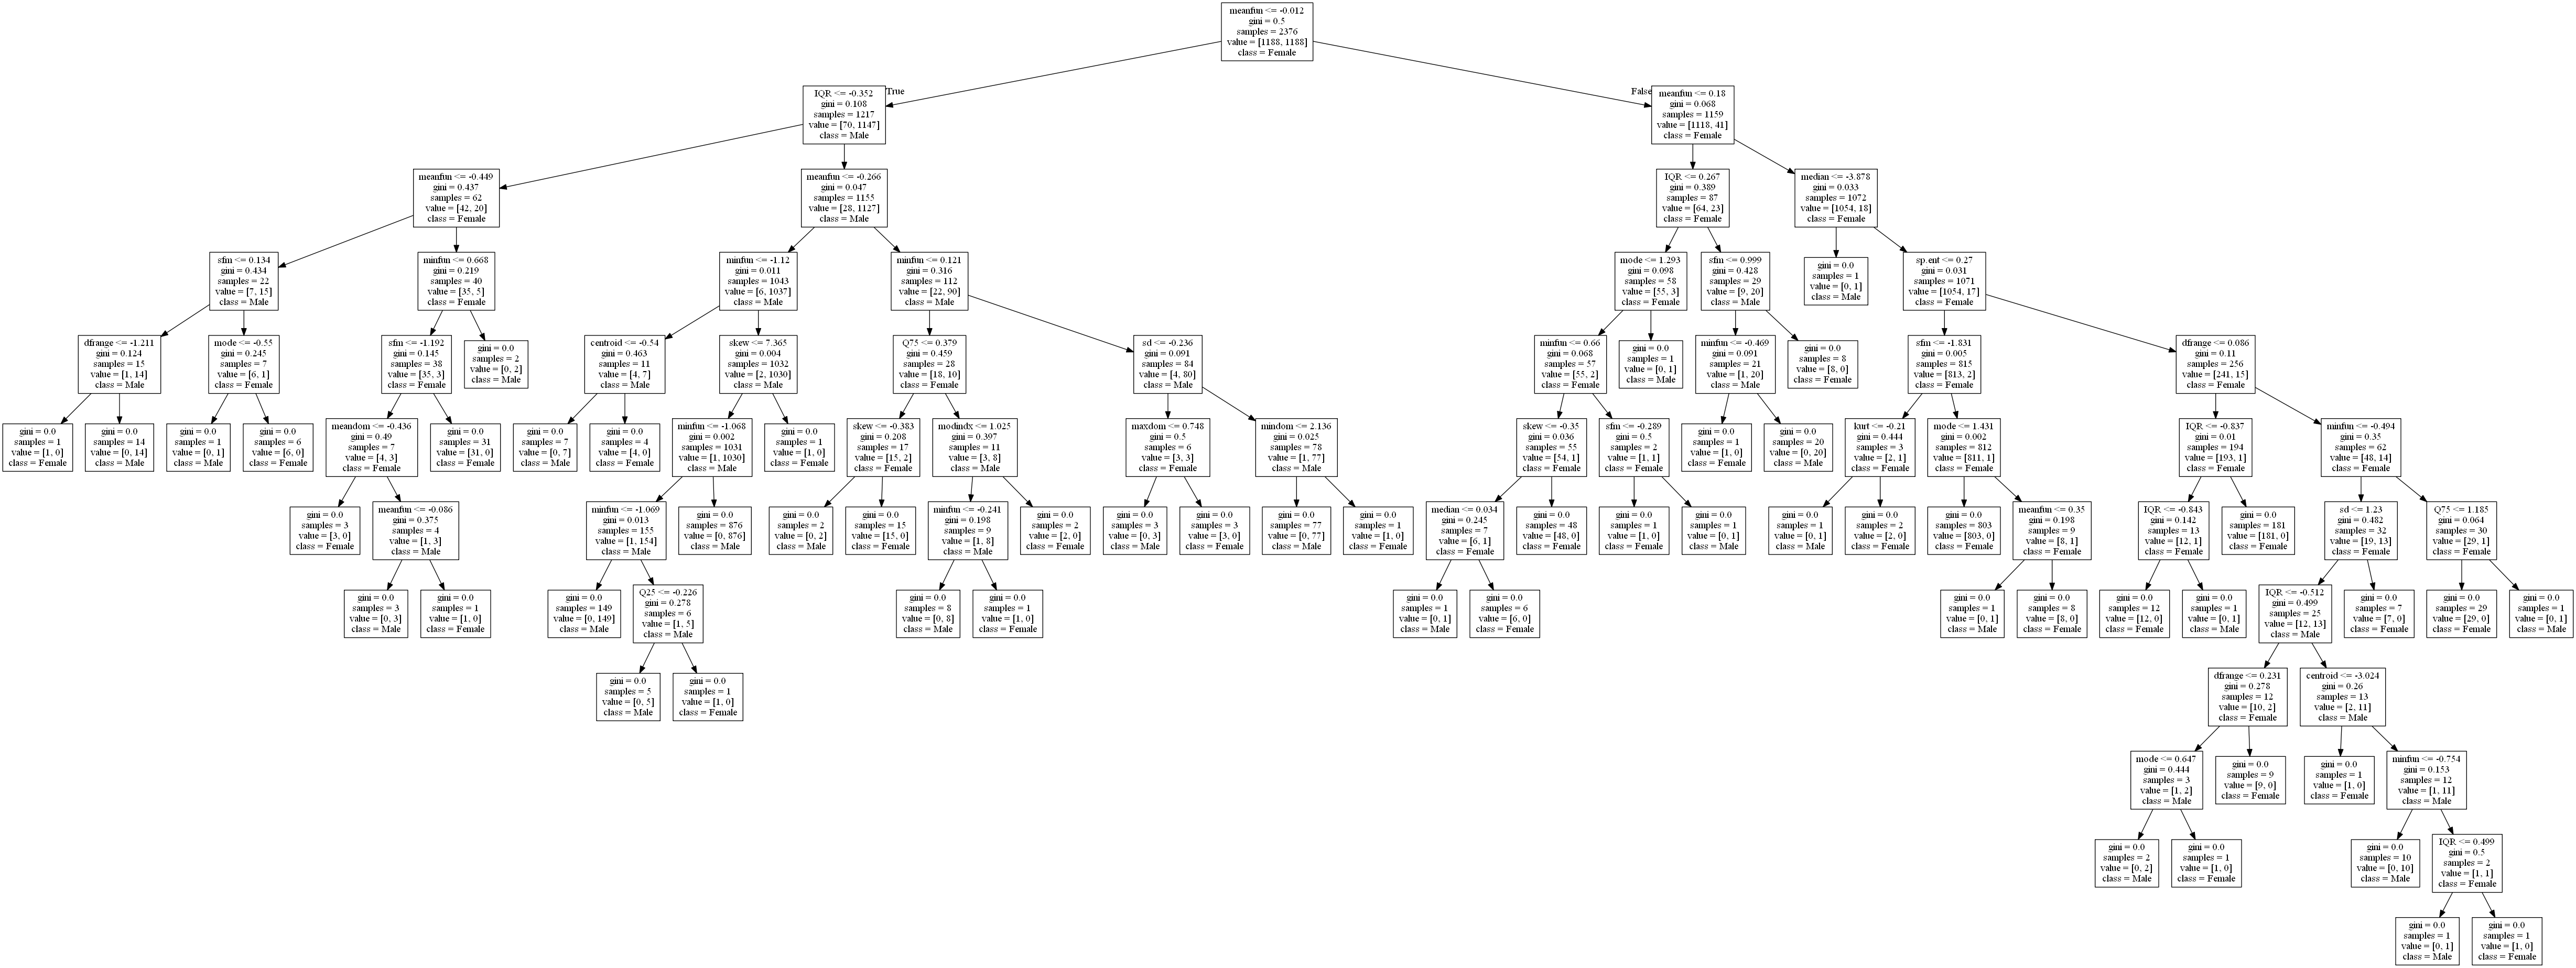

In [29]:
# Decision Tree plot
# Create the classifier
classifier = tree.DecisionTreeClassifier(max_depth=None)

# Fit the model
m_fit_time = %timeit -n1 -r1 -o classifier.fit(X_train_scaled, y_train.reshape(-1))

# Export the decision tree
dot_data = tree.export_graphviz( classifier, out_file = None,
                         class_names=['Female','Male'],
                         feature_names=X.columns)

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png() )


### Decision Tree - Scaled: Summary - Voice Dataset

In [30]:
summary_dt_voice_df = pd.DataFrame( model_results,
          columns=['Dataset', 'Classifier', 'Solver', 'Iterations', 'Total Iterations', 'Max Tree Depth', 'Fit Time (ms)', 'Score-Testing Data', 'Score-Training Data', 'Score-CV-Training Data', 'Score-CV-Training Data-Avg', 'Score-CV-Training Data-Std'])
summary_dt_voice_df

,Dataset,Classifier,Solver,Iterations,Total Iterations,Max Tree Depth,Fit Time (ms),Score-Testing Data,Score-Training Data,Score-CV-Training Data,Score-CV-Training Data-Avg,Score-CV-Training Data-Std
0,Voice,DecisionTreeClassifier,None,None,None,NaN,34.4601,0.969697,1.000000,"[0.9684873949579832, 0.9726890756302521, 0.966...",0.964213,0.006726
1,Voice,DecisionTreeClassifier,None,None,None,16.0,32.6105,0.972222,1.000000,"[0.9621848739495799, 0.9726890756302521, 0.951...",0.960433,0.006981
2,Voice,DecisionTreeClassifier,None,None,None,8.0,33.7408,0.974747,0.998316,"[0.9726890756302521, 0.9684873949579832, 0.960...",0.962109,0.008048
3,Voice,DecisionTreeClassifier,None,None,None,4.0,22.8408,0.976010,0.981061,"[0.9705882352941176, 0.9663865546218487, 0.962...",0.965908,0.002802
4,Voice,DecisionTreeClassifier,None,None,None,2.0,11.8950,0.963384,0.962542,"[0.9621848739495799, 0.9726890756302521, 0.960...",0.957895,0.011755
5,Voice,DecisionTreeClassifier,None,None,None,1.0,6.2311,0.955808,0.953283,"[0.957983193277311, 0.9663865546218487, 0.9495...",0.950739,0.010364


In [31]:
summary_dt_voice_df.mean()

Max Tree Depth                 6.200000
Fit Time (ms)                 23.629717
Score-Testing Data             0.968645
Score-Training Data            0.982534
Score-CV-Training Data-Avg     0.960216
Score-CV-Training Data-Std     0.007779
dtype: float64

## Overall Results

In [32]:
# Get the summary results for each set of classification runs
dt_iris_subset_df = summary_dt_iris_df[
    ['Dataset', 'Classifier',
                       'Solver', 'Iterations', 'Total Iterations',
                       'Max Tree Depth',
                       'Fit Time (ms)', 'Score-Testing Data', 'Score-Training Data',
                       'Score-CV-Training Data', 'Score-CV-Training Data-Avg', 'Score-CV-Training Data-Std']]

lr_iris_subset_df = summary_lr_iris_df[
    ['Dataset', 'Classifier',
                       'Solver', 'Iterations', 'Total Iterations',
                       'Max Tree Depth',
                       'Fit Time (ms)', 'Score-Testing Data', 'Score-Training Data',
                       'Score-CV-Training Data', 'Score-CV-Training Data-Avg', 'Score-CV-Training Data-Std']]

dt_voice_subset_df = summary_dt_voice_df[
    ['Dataset', 'Classifier',
                       'Solver', 'Iterations', 'Total Iterations',
                       'Max Tree Depth',
                       'Fit Time (ms)', 'Score-Testing Data', 'Score-Training Data',
                       'Score-CV-Training Data', 'Score-CV-Training Data-Avg', 'Score-CV-Training Data-Std']]

lr_voice_subset_df = summary_lr_voice_df[
    ['Dataset', 'Classifier',
                       'Solver', 'Iterations', 'Total Iterations',
                       'Max Tree Depth',
                       'Fit Time (ms)', 'Score-Testing Data', 'Score-Training Data',
                       'Score-CV-Training Data', 'Score-CV-Training Data-Avg', 'Score-CV-Training Data-Std']]

In [33]:
# Combine the results into an overall summary dataframe
overall_df = pd.concat([dt_iris_subset_df, lr_iris_subset_df,
                        dt_voice_subset_df, lr_voice_subset_df], sort=True).reset_index(drop=True)

overall_df = overall_df[['Dataset', 'Classifier',
                       'Solver', 'Iterations', 'Total Iterations',
                       'Max Tree Depth',
                       'Fit Time (ms)', 'Score-Testing Data', 'Score-Training Data',
                       'Score-CV-Training Data-Avg', 'Score-CV-Training Data-Std', 'Score-CV-Training Data']]

# Calculate the % "inflation" in the direct model score vs. cross-validation score average
overall_df['Score-Training-Inflation %'] = 100.0 * (overall_df['Score-Training Data'] - overall_df['Score-CV-Training Data-Avg']) / overall_df['Score-CV-Training Data-Avg']

overall_df

,Dataset,Classifier,Solver,Iterations,Total Iterations,Max Tree Depth,Fit Time (ms),Score-Testing Data,Score-Training Data,Score-CV-Training Data-Avg,Score-CV-Training Data-Std,Score-CV-Training Data,Score-Training-Inflation %
0,Iris,DecisionTreeClassifier,None,None,None,NaN,1.0084,0.973684,1.000000,0.914286,0.079200,"[0.875, 0.7916666666666666, 1.0, 0.90476190476...",9.375000
1,Iris,DecisionTreeClassifier,None,None,None,16,0.5846,0.973684,1.000000,0.914286,0.079200,"[0.875, 0.7916666666666666, 1.0, 0.90476190476...",9.375000
2,Iris,DecisionTreeClassifier,None,None,None,8,0.6209,0.973684,1.000000,0.932143,0.076931,"[0.9166666666666666, 0.7916666666666666, 1.0, ...",7.279693
3,Iris,DecisionTreeClassifier,None,None,None,4,0.4625,0.973684,0.973214,0.922619,0.076783,"[0.9166666666666666, 0.7916666666666666, 1.0, ...",5.483871
4,Iris,DecisionTreeClassifier,None,None,None,2,0.5242,0.947368,0.955357,0.928571,0.053901,"[0.9583333333333334, 0.875, 1.0, 0.85714285714...",2.884615
5,Iris,DecisionTreeClassifier,None,None,None,1,0.4465,0.657895,0.669643,0.669697,0.006061,"[0.6666666666666666, 0.6666666666666666, 0.681...",-0.008080
6,Iris,LogisticRegression,liblinear,[6],6,None,27.2255,0.894737,0.901786,0.888528,0.099701,"[0.875, 0.7083333333333334, 0.9545454545454546...",1.492083
7,Iris,LogisticRegression,newton-cg,"[10, 7, 8]",25,None,13.7873,0.947368,0.910714,0.896861,0.084940,"[0.875, 0.75, 0.9545454545454546, 1.0, 0.90476...",1.544588
8,Iris,LogisticRegression,lbfgs,"[13, 14, 15]",42,None,7.4660,0.947368,0.910714,0.896861,0.084940,"[0.875, 0.75, 0.9545454545454546, 1.0, 0.90476...",1.544588
9,Iris,LogisticRegression,sag,"[18, 23, 17]",58,None,4.4075,0.947368,0.910714,0.896861,0.084940,"[0.875, 0.75, 0.9545454545454546, 1.0, 0.90476...",1.544588


In [34]:
# Function: Gather data needed for plots for each Dataset and Classifier
def get_plot_data(a_x_col, a_y_col):
    
    # Sort the dataframe in ascending order by the column a_x_col
    sorted_df = overall_df.sort_values(by=a_x_col, ascending=True)
    
    plt_list = []
    plt_i = 0
    for ds in sorted_df['Dataset'].unique():
        for cls in sorted_df['Classifier'].unique():
            
            

            x_val = list(sorted_df[a_x_col]
                             [ (sorted_df['Dataset']==ds) & (sorted_df['Classifier']==cls) ])

            y_val = list(sorted_df[a_y_col]
                             [ (sorted_df['Dataset']==ds) & (sorted_df['Classifier']==cls) ])
            
            solver_val = list(sorted_df['Solver']
                             [ (sorted_df['Dataset']==ds) & (sorted_df['Classifier']==cls) 
                                & sorted_df['Solver'].notnull() ])

            tot_iter_val = list(sorted_df['Total Iterations']
                             [ (sorted_df['Dataset']==ds) & (sorted_df['Classifier']==cls) 
                                & sorted_df['Total Iterations'].notnull() ])

            max_depth_val = list(sorted_df['Max Tree Depth']
                             [ (sorted_df['Dataset']==ds) & (sorted_df['Classifier']==cls) 
                                & sorted_df['Max Tree Depth'].notnull() ])

            plt_info = {
                'title': f"Dataset {ds}/Classifer {cls}",
                'x_column': a_x_col,
                'x': x_val,
                'y_column': a_y_col,
                'y': y_val,
                'solver': solver_val,
                'tot_iter': tot_iter_val,
                'max_depth': max_depth_val
            }

            plt_list.append(plt_info)
            plt_i += 1
    return plt_list

In [35]:
# Function: Setup the axes and plots
def create_plot(a_ax, a_plt_info, a_limits = None):
    
    # Set the title
    a_ax.set_title(a_plt_info['title'])
    
    # If x and y axis limits have been provided, then use them
    # If not, then use default limits based upon the data
    try:
        x_min = a_limits['x_min']
    except:
        x_min = 0.5*min(a_plt_info['x'])

    try:
        x_max = a_limits['x_max']
    except:
        x_max = 1.15*max(a_plt_info['x'])

    try:
        y_min = a_limits['y_min']
    except:
#         y_min = min(0.6, 0.8*min(a_plt_info['y']) )
        y_min = 0.5*min(a_plt_info['y'])
    
    try:
        y_max = a_limits['y_max']
    except:
        y_max = 1.15*max(a_plt_info['y'])
    
    # Set the y-axis range to (0,1), normal range for model scores
    a_ax.set_ylim( y_min,y_max)
    a_ax.set_ylabel(a_plt_info['y_column'])

    # Set the x-axis minimum to 0 and maximum to the max Fit Time overall
    a_ax.set_xlim(x_min, x_max)
    a_ax.set_xlabel(a_plt_info['x_column'])
    
    # Plot the data
    a_ax.scatter( a_plt_info['x'], a_plt_info['y'], c="b" )
    
    # Plot a linear trend line
    z = np.polyfit(a_plt_info['x'], a_plt_info['y'], 1)
    p = np.poly1d(z)
    a_ax.plot( a_plt_info['x'], p(a_plt_info['x']), c="r", linestyle='-', linewidth=0.5 )
    
    # Add grid lines
    a_ax.grid(c='k', linestyle='-', linewidth=0.2)
    
    # Add text to key datapoints
    # Find the index of the value with the highest score
    i_highest = a_plt_info['y'].index( max(a_plt_info['y']) )
    
    # Find the index of the value with the lowest score
    i_lowest = a_plt_info['y'].index( min(a_plt_info['y']) )

    # Get the unique indices for the key datapoints using a Python Set
    # 0: First datapoint (i.e., lowest Fit Time)
    # -1: Last datapoint (i.e., highest Fit Time)
    i_set = set( [0, -1, i_lowest, i_highest] )
    
    # Plot a text note for each of the key datapoints
    for i in i_set:

        # Add text to the datapoint
        point_text = f"{a_plt_info['x_column']}: {a_plt_info['x'][i]:0.2f}\n{a_plt_info['y_column']}: {a_plt_info['y'][i]:0.2f}"

        try:
            point_text += f"\nSolver: {a_plt_info['solver'][i]}"
            point_text += f", Total Iterations: {a_plt_info['tot_iter'][i]}"

        except:
            pass

        try:
            point_text += f"\nMax Depth: {a_plt_info['max_depth'][i]}"
        except:
            pass

        # Place the text at an offset from the datapoint
        # x: No offset
        x_offset = 0
        
        # y: Offset by a fraction of the y-axis max-min range,
        #    and positive for even indices, negative for odd indices
        #    (to try to avoid overlap between adjacent datapoints)
        y_offset = (y_max-y_min)/20 * ( 1 if i % 2 == 0 else -2.5 )
        a_ax.text( a_plt_info['x'][i] + x_offset, a_plt_info['y'][i] + y_offset,
                   point_text, c="#0000FFFF" )
        

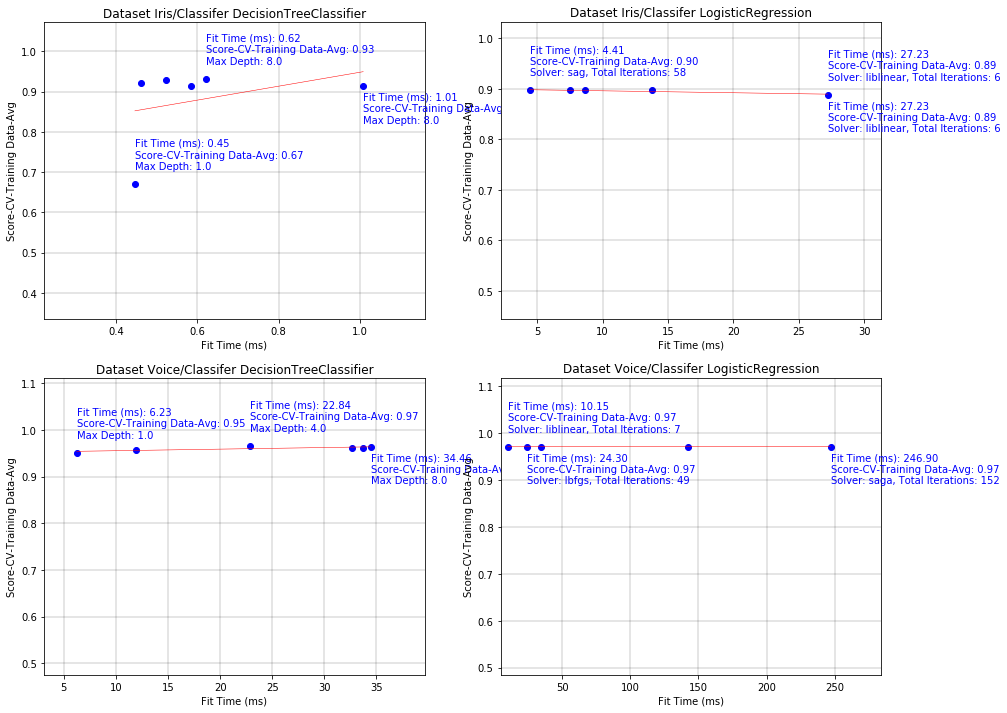

In [36]:
# Plot: Cross Validation Score on Test data vs. Fit Time
x_column = 'Fit Time (ms)'
# y_column = 'Score-Testing Data'
y_column = 'Score-CV-Training Data-Avg'

p_info_list = get_plot_data(x_column, y_column)
# pprint(p_info_list)

# Plot Classification Performance results
fig1 = plt.figure(figsize=(15,12))
ax_list = []
p_i = 0

for p_info in p_info_list:
    ax_list.append( fig1.add_subplot(2, math.ceil(len(p_info_list)/2), p_i+1) )
    create_plot(ax_list[p_i], p_info)
    p_i += 1
        
# Save the image - use it for Summary of Analysis at the top of the notebook
plt.savefig('docs/Figure-Cross_Validation_DecisionTree_and_LogisticRegression.png', bbox_inches='tight')

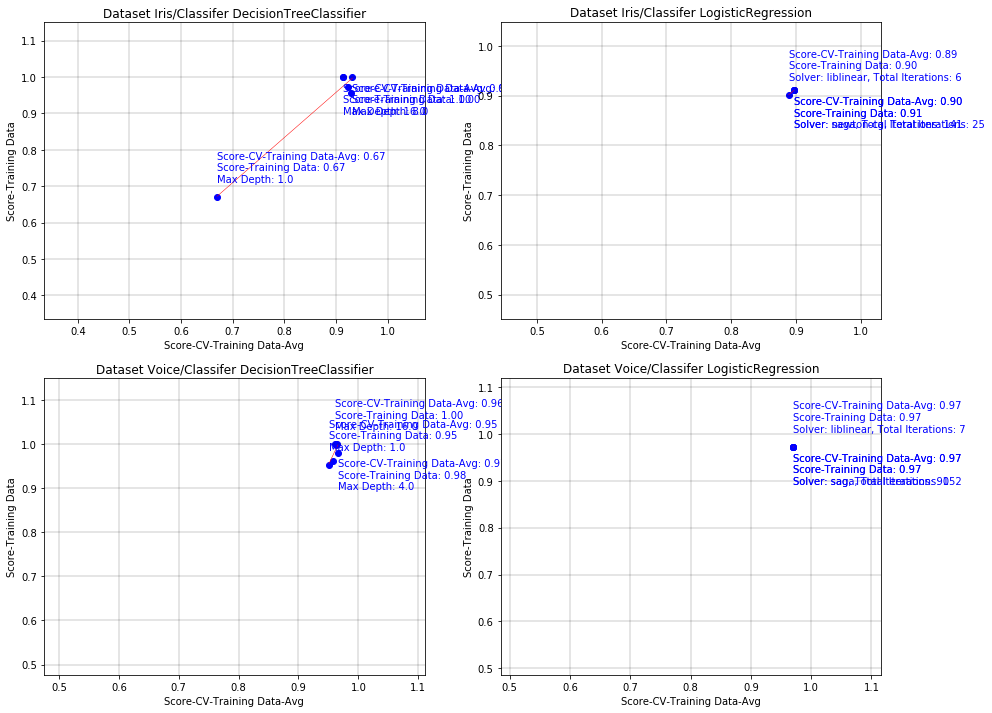

In [37]:
# Plot: Direct Scoring vs. Cross-Validation Avg score
x_column = 'Score-CV-Training Data-Avg'
y_column = 'Score-Training Data'

p_info_list = get_plot_data(x_column, y_column)
# pprint(p_info_list)

# Plot Classification Performance results
fig1 = plt.figure(figsize=(15,12))
ax_list = []
p_i = 0

for p_info in p_info_list:
    ax_list.append( fig1.add_subplot(2, math.ceil(len(p_info_list)/2), p_i+1) )
    create_plot(ax_list[p_i], p_info)
    p_i += 1
        
# Save the image - use it for Summary of Analysis at the top of the notebook
plt.savefig('docs/Figure-Cross_Validation_vs_Direct.png', bbox_inches='tight')

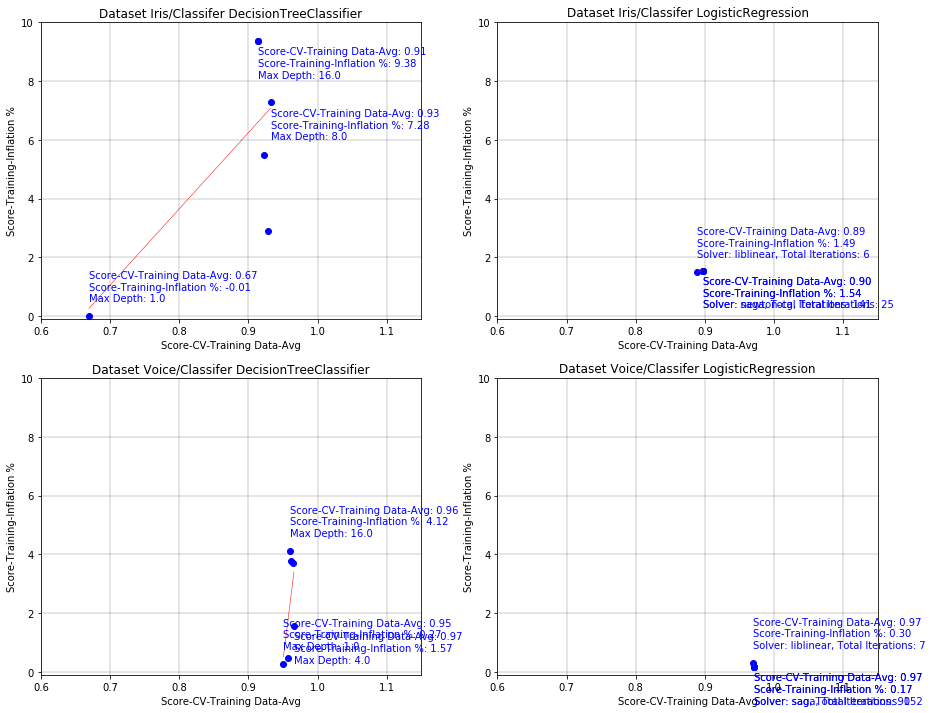

In [38]:
# Plot: Cross Validation score vs. Inflation of [Training score vs. cross-validation avg]
x_column = 'Score-CV-Training Data-Avg'
# y_column = 'Score-CV-Training Data-Avg'
y_column = 'Score-Training-Inflation %'

p_info_list = get_plot_data(x_column, y_column)
# pprint(p_info_list)

# Plot Classification Performance results
fig1 = plt.figure(figsize=(15,12))
ax_list = []
p_i = 0

for p_info in p_info_list:
    ax_list.append( fig1.add_subplot(2, math.ceil(len(p_info_list)/2), p_i+1) )
    create_plot(ax_list[p_i], p_info,
               {
                   'x_min': 0.6,
                   'x_max': 1.15,
                   'y_min': -0.1,
                   'y_max': 10.0
               })
    p_i += 1
        
# Save the image - use it for Summary of Analysis at the top of the notebook
plt.savefig('docs/Figure-Cross_Validation_vs_Direct.png', bbox_inches='tight')

In [39]:
table_df = overall_df[['Dataset', 'Classifier', 'Solver', 'Iterations', 'Total Iterations',
       'Max Tree Depth', 'Score-Testing Data',
       'Score-Training Data', 'Score-CV-Training Data-Avg',
       'Score-Training-Inflation %']] \
        .sort_values(by=['Score-Testing Data','Score-CV-Training Data-Avg'], ascending=[False, True])

table_df = table_df.round(4)
table_df

,Dataset,Classifier,Solver,Iterations,Total Iterations,Max Tree Depth,Score-Testing Data,Score-Training Data,Score-CV-Training Data-Avg,Score-Training-Inflation %
17,Voice,LogisticRegression,liblinear,[7],7,None,0.9773,0.9731,0.9701,0.3036
18,Voice,LogisticRegression,newton-cg,[14],14,None,0.9773,0.9722,0.9705,0.1733
19,Voice,LogisticRegression,lbfgs,[49],49,None,0.9773,0.9722,0.9705,0.1733
20,Voice,LogisticRegression,sag,[90],90,None,0.9773,0.9722,0.9705,0.1733
21,Voice,LogisticRegression,saga,[152],152,None,0.9773,0.9722,0.9705,0.1733
14,Voice,DecisionTreeClassifier,None,None,None,4,0.9760,0.9811,0.9659,1.5688
13,Voice,DecisionTreeClassifier,None,None,None,8,0.9747,0.9983,0.9621,3.7634
0,Iris,DecisionTreeClassifier,None,None,None,NaN,0.9737,1.0000,0.9143,9.3750
1,Iris,DecisionTreeClassifier,None,None,None,16,0.9737,1.0000,0.9143,9.3750
3,Iris,DecisionTreeClassifier,None,None,None,4,0.9737,0.9732,0.9226,5.4839


C:\Users\Jeff\AppData\Local\conda\conda\envs\PythonData\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


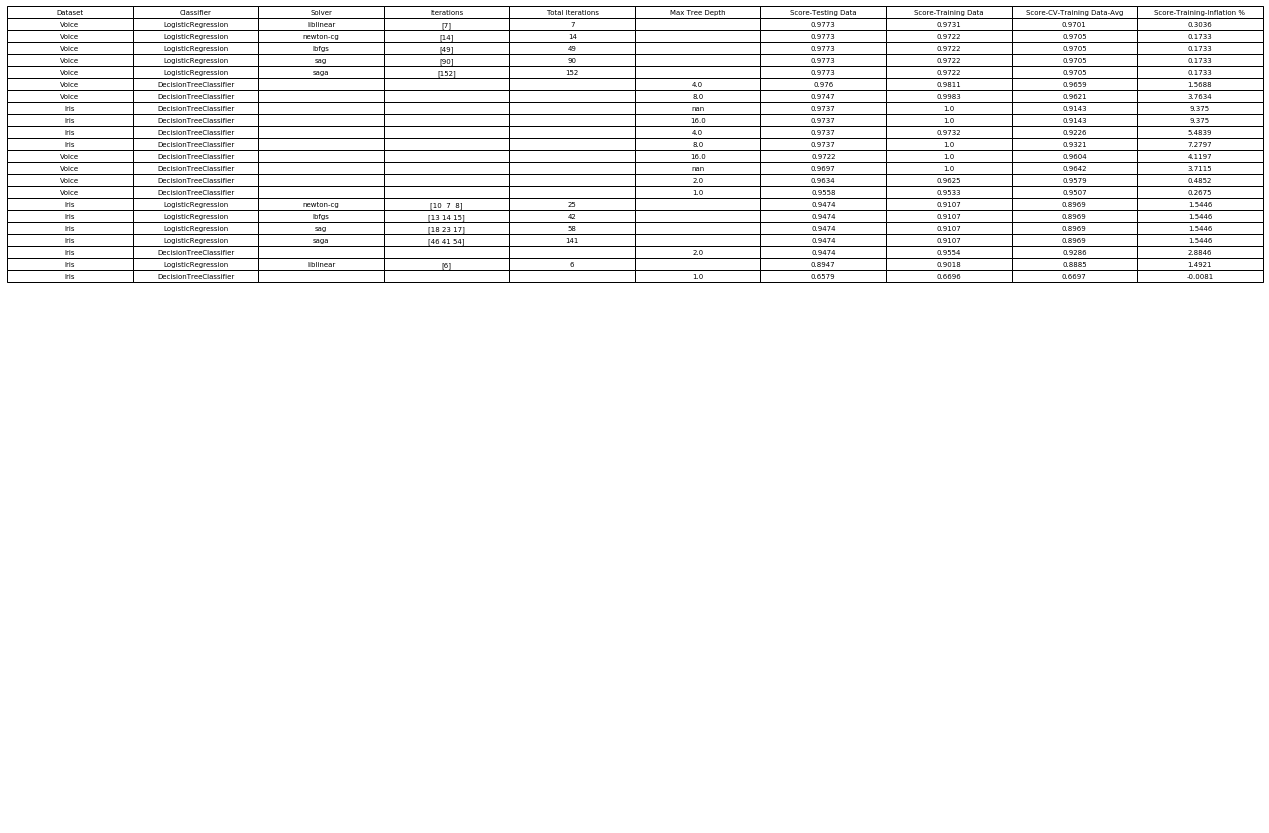

In [40]:
# Table: Performance results
# fig_table_1 = plt.figure(figsize=(15,12))
fig_table_1 = plt.figure(figsize=(15,10))

# Create axes for this table, but with no visible frame
ax_table = fig_table_1.add_subplot(111, frame_on=False)

# Hide the x and y axes
ax_table.xaxis.set_visible(False)
ax_table.yaxis.set_visible(False)

plt.table(cellText=table_df.values,
          colWidths = [0.15]*len(table_df.columns),
#           rowLabels=table_df.index,
          colLabels=table_df.columns,
          cellLoc = 'center', rowLoc = 'center',
          loc='top')

# Show the resulting table
plt.show()
        
# Save the image - use it for Summary of Analysis at the top of the notebook
fig_table_1.savefig('docs/Table-Cross_Validation_vs_Direct.png', bbox_inches='tight') 